## Logistics

We are going to use parallel-tempering, implemented via the python emcee package, to explore our posterior, which consists of the set of distances and gas to dust conversion coefficients to the twelve velocity slices. Since we need to explore a 24 dimensional parameter space, we are going to use 100 walkers, 500 steps each, at 5 different temperatures. If you would like to edit this parameters, simply edit "nwalkers", "ntemps", and "nsteps" in the cell below. However, we are only going to keep the lowest temperature chain ($\beta=1$) for analysis. Since the sampler.chain object from PTSampler returns an array of shape (Ntemps, Nwalkers, Nsteps, Ndim), returning the samples for all walkers, steps, and dimensions at $\beta=1$ would correspond to sampler.chain[0,:,:,:]. To decrease your value of $\beta$ simply increase the index for the first dimension. For more information on how PTSampler works, see http://dan.iel.fm/emcee/current/user/pt/. We will set off our walkers in a Gaussian ball around a) the kinematic distance estimates for the Cepheus molecular cloud given by a flat rotation curve from Leroy & Rosolowsky 2006 and b) the gas-to-dust coefficient given by the literature. We perturb the walkers in a Gaussian ball with mean 0 and variance 1. You can edit the starting positions of the walkers by editing the "result" variable below. We are going to discard the first half of every walker's chain as burn-in. 

### Setting up the positional arguments for PTSampler

We need to feed PTSampler the required positional arguments for the log_likelihood and log_prior function. We do this using the fetch_args function from the io module, which creates an instance of the pixclass object that holds our data and metadata. Fetch_args accepts three arguments: 

- A string specifiying the h5 filename containing your data, in our case 89996.h5
- The prior bounds you want to impose on a) distances (flat prior), in units of distance modulus and b) gas to dust coefficients (also flat prior). In the script, we multiply our input literature value of choice by this prefactor. The bounds are given as a list in the format [lower_distance, upper_distance, lower_coefficient, upper_coefficient]. For distance, this must be between 4 and 19, because that's the distance modulus range of our stellar posterior array. 
- The gas-to-dust coefficient you'd like to use, given as a float; for this tutorial, we are pulling a value from the literature of 0.06 magnitudes/K. This value is then multiplied by the set of c coefficients we're determining as part of the parameter estimation problem. 

Fetch_args will then return the correct arguments for the log_likelihood and log_prior functions within the model module. 

Here we go!

In [1]:
import emcee
from dustcurve import model
import seaborn as sns
import numpy as np
from dustcurve import pixclass
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io
from dustcurve import hputils
from dustcurve import kdist
%matplotlib inline

#this code pulls snippets from the PHYS201 week 9 MCMC notebook written by Vinny Manohoran and the PHYS201 L9 solutions,
#written by Tom Dimiduk and Kevin Shain

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

#our nside 128 pixel of choice
fnames='89996.h5'

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args(fnames,[4,19,0,100],0.06)

# the model has 24 parameters; we'll use 50 walkers, 1000 steps each, at 5 different temps
ndim=24
nslices=12
nwalkers = 50
nsteps = 1000
ntemps=5

#setting off the walkers at the kinematic distance given by the literature, assuming a flat rotation curve, theta=220 km/s, R=8.5 kpc
#Details on rotation curve given in Rosolowsky and Leroy 2006
vslices=np.linspace(-15.6,-1.3,12)
klong=np.ones(12)*hputils.pix2lb_scalar(128,int(fnames[:-3]))[0]
klat=np.ones(12)*hputils.pix2lb_scalar(128,int(fnames[:-3]))[1]
kdist=kdist.kdist(klong,klat,vslices)
kdistmod=5*np.log10(kdist)-5

#slightly perturb the starting positions for each walker, in a ball centered around result
result=kdistmod.tolist()
result.extend(1.0 for i in range (nslices))
starting_positions = [[result + np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model.log_likelihood, model.log_prior, loglargs=(ldata), logpargs=[pdata])

#burn in, and save final positions for all parameters, which we'll then set off our walkers at for the "real" thing
post_burn_pos, prob, state = sampler.run_mcmc(starting_positions, 300)

#find autocorrelation times:
autocorr=sampler.get_autocorr_time()
autocorr_cold=autocorr[0,:]
#we are going to thin according to the mean autocorrelation time
thin_int=int(np.mean(autocorr_cold))
sampler.reset()

print("Setup complete")

/n/home12/czucker/envs/PYTHON3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Total number of stars used in analysis: 3065
Setup complete


In [2]:
# run the sampler and time how long it takes
%time sampler.run_mcmc(post_burn_pos, nsteps) #, thin=thin_int)
print('Sampler Done')

CPU times: user 7min 37s, sys: 30 ms, total: 7min 37s
Wall time: 7min 37s
Sampler Done


The sampler is done running, so now let's check out the results. We are going to print out our mean acceptance fraction across all walkers for the coldest temperature chain. 

We are going to discard the first half of each walker's chain as burn-in; to change the number of steps to burn off, simply edit the 3rd dimension of sampler.chain[0,:,n:,:] and input your desired value of n. Next we are going to plot what the chains look like, for all distances and conversion coefficients. Finally, we are going to compute and print out the 50th, 16th, and 84th percentile of chain for each distance parameter, using the "quantile" attribute of a pandas dataframe object. The 50th percentile measurement represents are best guess for the each distance parameter, while the difference between the 16th and 50th gives us a lower limit and the difference between the 50th and 84th percentile gives us an upper limit.

In [3]:
#Extract the coldest [beta=1] temperature chain from the sampler object; discard first half of samples as burnin
samples_cold = sampler.chain[0,:,int(nsteps/2):,:]
traces_cold = samples_cold.reshape(-1, ndim).T

#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#find best fit values for each of the 24 parameters (12 d's and 12 c's)
theta=pd.DataFrame(traces_cold)
quantile_50=theta.quantile(.50, axis=1).values
quantile_84=theta.quantile(.84, axis=1).values
quantile_16=theta.quantile(.16, axis=1).values

upperlim=quantile_84-quantile_50
lowerlim=quantile_50-quantile_16

#print out distances
for i in range(0,int(len(quantile_50)/2)):
    print('d%i: %.3f + %.3f - %.3f' % (i+1,quantile_50[i],upperlim[i], lowerlim[i]))

#print out coefficients
for i in range(int(len(quantile_50)/2), int(len(quantile_50))):
    print('c%i: %.3f + %.3f - %.3f' % (i+1-int(len(quantile_50)/2),quantile_50[i],upperlim[i], lowerlim[i]))


Our mean acceptance fraction for the coldest chain is 0.06
d1: 7.137 + 1.358 - 0.510
d2: 10.050 + 0.319 - 0.168
d3: 10.245 + 0.437 - 0.276
d4: 9.750 + 0.084 - 0.074
d5: 9.463 + 0.148 - 0.657
d6: 4.525 + 1.248 - 0.345
d7: 7.998 + 0.711 - 0.646
d8: 7.458 + 0.556 - 0.316
d9: 4.652 + 0.905 - 0.314
d10: 6.881 + 0.271 - 0.908
d11: 5.731 + 1.018 - 0.538
d12: 7.374 + 0.645 - 1.238
c1: 0.476 + 0.644 - 0.237
c2: 2.924 + 0.391 - 0.567
c3: 0.709 + 0.220 - 0.486
c4: 3.334 + 0.589 - 0.184
c5: 1.324 + 0.177 - 0.212
c6: 0.072 + 0.066 - 0.041
c7: 0.209 + 0.207 - 0.153
c8: 0.360 + 0.547 - 0.226
c9: 0.607 + 0.163 - 0.238
c10: 4.277 + 0.401 - 1.080
c11: 0.323 + 0.514 - 0.203
c12: 1.705 + 0.897 - 0.435


Let's see what our chains look like by producing trace plots:

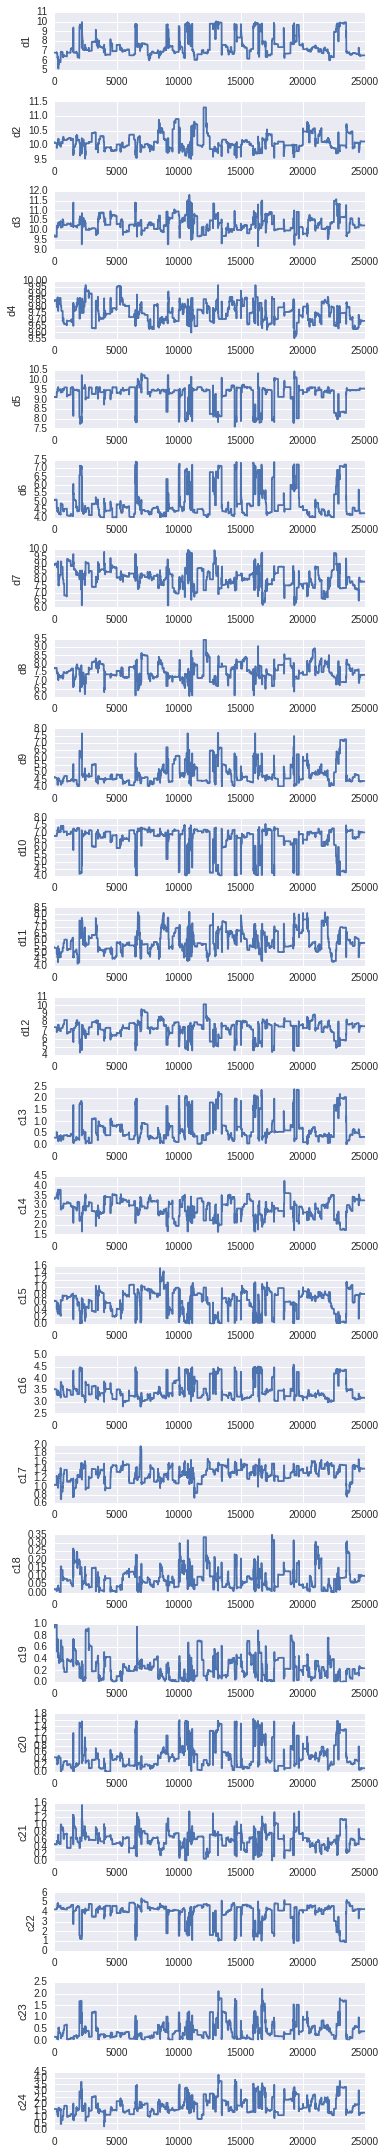

In [4]:
#set up subplots for chain plotting
axes=['ax'+str(i) for i in range(ndim)]
fig, (axes) = plt.subplots(ndim, figsize=(5,30))

plt.tight_layout()

for i in range(0,ndim):
    if i<int(ndim/2):
        axes[i].set(ylabel='d%i' % (i+1))
    else:
        axes[i].set(ylabel='c%i' % (i+1))

#plot traces for each parameter
for i in range(0,ndim):
    sns.tsplot(traces_cold[i],ax=axes[i])


Now let's overplot the reddening profiles corresponding to our most probable parameters on top of the stacked stellar posterior surfaces. This plot has been normalized so that a) each individual stellar posterior array sums to one and b) each distance column in the stacked posterior array contains the same amount of "ink"

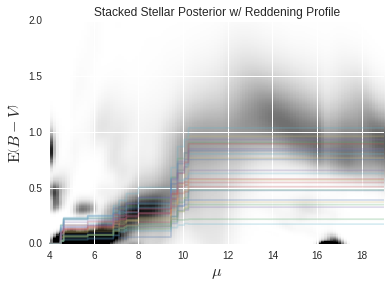

In [5]:
from dustcurve import pixclass
pixObj=pixclass.PixStars('/n/fink1/czucker/Data/'+ fnames)
post_array=pixObj.get_p()

unique_co,indices,unique_post,ratio=ldata

from dustcurve import plot_posterior
#plot the reddening profile over the stacked, normalized stellar posterior surfaces    
plot_posterior.plot_posterior(np.asarray(post_array),np.linspace(4,19,120),np.linspace(0,7,700),quantile_50,ratio,unique_co,y_range=[0,2],vmax=0.03)


Now that we know how our code works, let's run a Gelman-Rubin test. We are going to determine the Gelman-Rubin convergence diagnostic for every parameter. We'll use the same number of walkers (50) and steps (1000) as before, except now we are running 5 independent chains and checking if these chains converge for all parameters, for the coldest temperature. 

In [10]:
from dustcurve import diagnostics

gr,chain_ensemble=diagnostics.run_chains(fnames,nwalkers=50,nsteps=1000,runs=5, bounds=[4,19,0,100])

Total number of stars used in analysis: 3065


In [11]:
print(gr)

[ 2.20876943  4.15567409  1.18891779  6.75133441  3.19455271  2.5507578
  1.90963641  2.90168416  2.02870465  1.60608161  3.86718889  2.21471694
  2.19309404  3.08382865  1.21342145  4.93235123  3.64247818  1.4711442
  1.24079396  1.48894681  1.27256702  2.42115845  2.0153013   2.8507325 ]


Since all of our parameters have a GR diagnostic > 1.1, it's obvious that none of these parameters have converged to our target, stationary distribution...

Now let's save the results to a file!

In [6]:
import h5py
#Save the results of the sampler:
output=fnames

fwrite = h5py.File("/n/fink1/czucker/Output/"+str(output), "w")
chaindata = fwrite.create_dataset("/chains", sampler.chain.shape, dtype='f')
chaindata[:,:,:,:]=sampler.chain
    
probdata = fwrite.create_dataset("/probs", sampler.lnprobability.shape, dtype='f')
probdata[:,:,:]=sampler.lnprobability

fwrite.close()